In [2]:
import math
import random
import time
import torch
import torch.optim as optim

from mlagents_envs.environment import UnityEnvironment
from mlagents_envs.base_env import ActionTuple

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from models import DQN, DuelingDQN, ReplayMemory, optimize_model

def select_action(state_in):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            action_out = policy_net(state_in).max(1).indices.view(1, 1)
            return action_out
    else:
        return torch.tensor(spec.action_spec.random_action(1).discrete, device=device, dtype=torch.long)


In [3]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.1
EPS_DECAY = 100_000
TAU = 0.005
LR = 1e-4

SAVE_WEIGHTS = True
LOAD_WEIGHTS = False
steps_done = 0
STEPS = 250
DOUBLE = True
DUELING = False
GRAPHICS = False

if torch.cuda.is_available():
    num_episodes = 10_000
else:
    num_episodes = 50


In [4]:

env = UnityEnvironment(file_name="unity_builds/snake", seed=1, side_channels=[], no_graphics=not GRAPHICS)
env.reset()

behaviour_name = list(env.behavior_specs)[0]
spec = env.behavior_specs[behaviour_name]

n_actions = spec.action_spec.discrete_branches[0]
state, _ = env.get_steps(behaviour_name)
state = state.obs[0]
n_observations = spec.observation_specs[0].shape[0]

if DUELING:
    policy_net = DuelingDQN(n_observations, n_actions).to(device)
    target_net = DuelingDQN(n_observations, n_actions).to(device)
else:
    policy_net = DQN(n_observations, n_actions).to(device)
    target_net = DQN(n_observations, n_actions).to(device)

if LOAD_WEIGHTS:
    policy_net.load_state_dict(torch.load('weights/policy_net.pth'))
    print("Loaded weights from file")

target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(1000)
print(f"Initalized DQN with {n_observations} observations and {n_actions} actions")
rewards = []
losses = []
lengths = []

Initalized DQN with 29 observations and 4 actions


In [5]:
timer_start = time.perf_counter()
pbar = tqdm(range(num_episodes))
for i_episode in pbar:
    if i_episode % 100 == 0 and i_episode != 0:
        print(
            f"Episode {i_episode}, avg reward: {np.mean(rewards[-100:]):.2f}, "
            f"epsilon: {EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY):.2f}")
        torch.save(policy_net.state_dict(), 'weights/policy_net.pth')
        print("Checkpoint: Saved weights to file")
    step_rewards = []
    step_losses = []
    episode_length = []

    env.reset()
    decision_steps, terminal_steps = env.get_steps(behaviour_name)
    state = decision_steps.obs[0]
    state = torch.tensor(state, dtype=torch.float32, device=device)
    for t in range(STEPS):
        action = select_action(state)
        action_tuple = ActionTuple()
        action_tuple.add_discrete(action.cpu().numpy())
        env.set_actions(behaviour_name, action_tuple)
        env.step()

        assert action.shape[0] == state.shape[0]

        decision_steps, terminal_steps = env.get_steps(behaviour_name)
        observation = decision_steps.obs[0]
        reward = np.zeros(state.shape[0])
        if len(decision_steps.reward) > 0:
            reward += decision_steps.reward
        if len(terminal_steps.reward) > 0:
            reward += terminal_steps.reward
        done = len(decision_steps) == 0
        terminated = len(terminal_steps) > 0

        assert len(reward) == state.shape[0] == action.shape[0]

        # if t % 50 == 0:
        #     print(f"step: {t}, reward: {reward}, state: {state}, action: {action}")
        reward = torch.tensor(reward, device=device)
        step_rewards.append(reward.item())

        if done or terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device)

        memory.push(state, action, next_state, reward)
        state = next_state
        loss = optimize_model(memory, policy_net, target_net, optimizer, device, double=DOUBLE, BATCH_SIZE=BATCH_SIZE, GAMMA=GAMMA)
        if loss is not None:
            step_losses.append(loss)

        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key] * TAU + target_net_state_dict[key] * (1 - TAU)
        target_net.load_state_dict(target_net_state_dict)

        if terminated or done:
            episode_length.append(t)
            break
    
    if len(step_losses) == 0:
        step_losses.append(0)
    losses.append(np.mean(step_losses))
    lengths.append(np.mean(episode_length))
    ep_rewards = sum(step_rewards)
    pbar.set_description(f"E {i_episode} done after {t + 1} t, with r: {ep_rewards:.2f} and l: {np.mean(step_losses):.2f}")
    rewards.append(ep_rewards)

env.close()
print(f"Finished training in {(time.perf_counter() - timer_start)/60 :.3} minutes")


E 99 done after 60 t, with r: 1.40 and l: 0.00:   1%|          | 100/10000 [02:12<2:52:21,  1.04s/it] 

Episode 100, avg reward: -0.16, epsilon: 0.85
Checkpoint: Saved weights to file


E 199 done after 35 t, with r: 0.90 and l: 0.01:   2%|▏         | 200/10000 [04:12<2:57:10,  1.08s/it]  

Episode 200, avg reward: 0.28, epsilon: 0.81
Checkpoint: Saved weights to file


E 299 done after 36 t, with r: 1.00 and l: 0.01:   3%|▎         | 300/10000 [06:05<2:35:23,  1.04it/s]  

Episode 300, avg reward: 0.40, epsilon: 0.77
Checkpoint: Saved weights to file


E 399 done after 49 t, with r: 1.70 and l: 0.00:   4%|▍         | 400/10000 [07:52<2:25:58,  1.10it/s] 

Episode 400, avg reward: 0.56, epsilon: 0.73
Checkpoint: Saved weights to file


E 500 done after 3 t, with r: -1.10 and l: 0.00:   5%|▌         | 500/10000 [09:09<1:26:50,  1.82it/s] 

Episode 500, avg reward: 0.66, epsilon: 0.71
Checkpoint: Saved weights to file


E 600 done after 4 t, with r: 0.20 and l: 0.00:   6%|▌         | 601/10000 [10:38<1:22:57,  1.89it/s]   

Episode 600, avg reward: 0.68, epsilon: 0.68
Checkpoint: Saved weights to file


E 699 done after 33 t, with r: 1.70 and l: 0.00:   7%|▋         | 700/10000 [12:01<1:56:56,  1.33it/s] 

Episode 700, avg reward: 0.95, epsilon: 0.66
Checkpoint: Saved weights to file


E 799 done after 50 t, with r: 1.80 and l: 0.00:   8%|▊         | 800/10000 [13:20<2:07:10,  1.21it/s] 

Episode 800, avg reward: 0.76, epsilon: 0.64
Checkpoint: Saved weights to file


E 899 done after 43 t, with r: 2.10 and l: 0.00:   9%|▉         | 900/10000 [14:32<2:26:56,  1.03it/s] 

Episode 900, avg reward: 0.91, epsilon: 0.62
Checkpoint: Saved weights to file


E 999 done after 30 t, with r: 1.00 and l: 0.01:  10%|█         | 1000/10000 [15:48<2:28:50,  1.01it/s]

Episode 1000, avg reward: 1.08, epsilon: 0.60
Checkpoint: Saved weights to file


E 1100 done after 1 t, with r: -1.10 and l: 0.00:  11%|█         | 1100/10000 [16:50<1:22:37,  1.80it/s] 

Episode 1100, avg reward: 0.93, epsilon: 0.59
Checkpoint: Saved weights to file


E 1199 done after 26 t, with r: 1.00 and l: 0.00:  12%|█▏        | 1200/10000 [17:58<1:07:30,  2.17it/s] 

Episode 1200, avg reward: 0.96, epsilon: 0.57
Checkpoint: Saved weights to file


E 1299 done after 46 t, with r: 3.40 and l: 0.01:  13%|█▎        | 1300/10000 [19:04<1:45:19,  1.38it/s] 

Episode 1300, avg reward: 1.04, epsilon: 0.56
Checkpoint: Saved weights to file


E 1399 done after 30 t, with r: 1.60 and l: 0.00:  14%|█▍        | 1400/10000 [20:12<1:36:35,  1.48it/s]

Episode 1400, avg reward: 1.14, epsilon: 0.54
Checkpoint: Saved weights to file


E 1499 done after 22 t, with r: 0.60 and l: 0.00:  15%|█▌        | 1500/10000 [21:12<1:13:21,  1.93it/s] 

Episode 1500, avg reward: 1.09, epsilon: 0.53
Checkpoint: Saved weights to file


E 1599 done after 27 t, with r: 0.50 and l: 0.01:  16%|█▌        | 1600/10000 [22:21<1:28:10,  1.59it/s] 

Episode 1600, avg reward: 1.19, epsilon: 0.52
Checkpoint: Saved weights to file


E 1699 done after 59 t, with r: 1.30 and l: 0.00:  17%|█▋        | 1700/10000 [23:24<2:05:00,  1.11it/s] 

Episode 1700, avg reward: 1.17, epsilon: 0.50
Checkpoint: Saved weights to file


E 1799 done after 34 t, with r: 1.00 and l: 0.01:  18%|█▊        | 1800/10000 [24:31<1:11:25,  1.91it/s] 

Episode 1800, avg reward: 1.33, epsilon: 0.49
Checkpoint: Saved weights to file


E 1899 done after 18 t, with r: 0.60 and l: 0.01:  19%|█▉        | 1900/10000 [25:32<55:33,  2.43it/s]   

Episode 1900, avg reward: 1.29, epsilon: 0.48
Checkpoint: Saved weights to file


E 1999 done after 43 t, with r: 1.50 and l: 0.00:  20%|██        | 2000/10000 [26:27<1:36:21,  1.38it/s] 

Episode 2000, avg reward: 1.17, epsilon: 0.47
Checkpoint: Saved weights to file


E 2099 done after 45 t, with r: 2.90 and l: 0.00:  21%|██        | 2100/10000 [27:26<1:44:00,  1.27it/s] 

Episode 2100, avg reward: 1.21, epsilon: 0.46
Checkpoint: Saved weights to file


E 2200 done after 2 t, with r: -1.20 and l: 0.01:  22%|██▏       | 2200/10000 [28:26<1:38:59,  1.31it/s] 

Episode 2200, avg reward: 1.55, epsilon: 0.45
Checkpoint: Saved weights to file


E 2299 done after 22 t, with r: 1.20 and l: 0.00:  23%|██▎       | 2300/10000 [29:18<55:32,  2.31it/s]  

Episode 2300, avg reward: 1.19, epsilon: 0.44
Checkpoint: Saved weights to file


E 2399 done after 56 t, with r: 2.40 and l: 0.00:  24%|██▍       | 2400/10000 [30:15<1:37:45,  1.30it/s] 

Episode 2400, avg reward: 1.26, epsilon: 0.43
Checkpoint: Saved weights to file


E 2499 done after 15 t, with r: 0.70 and l: 0.00:  25%|██▌       | 2500/10000 [31:12<1:10:22,  1.78it/s] 

Episode 2500, avg reward: 1.43, epsilon: 0.42
Checkpoint: Saved weights to file


E 2599 done after 13 t, with r: 0.70 and l: 0.00:  26%|██▌       | 2600/10000 [32:08<1:07:50,  1.82it/s] 

Episode 2600, avg reward: 1.40, epsilon: 0.41
Checkpoint: Saved weights to file


E 2699 done after 29 t, with r: 3.10 and l: 0.00:  27%|██▋       | 2700/10000 [32:59<1:21:11,  1.50it/s]

Episode 2700, avg reward: 1.42, epsilon: 0.41
Checkpoint: Saved weights to file


E 2799 done after 37 t, with r: 2.10 and l: 0.00:  28%|██▊       | 2800/10000 [34:03<1:25:07,  1.41it/s] 

Episode 2800, avg reward: 1.70, epsilon: 0.40
Checkpoint: Saved weights to file


E 2899 done after 73 t, with r: 3.70 and l: 0.01:  29%|██▉       | 2900/10000 [35:06<2:00:32,  1.02s/it] 

Episode 2900, avg reward: 1.57, epsilon: 0.39
Checkpoint: Saved weights to file


E 2999 done after 24 t, with r: -0.40 and l: 0.01:  30%|███       | 3000/10000 [36:07<1:12:37,  1.61it/s]

Episode 3000, avg reward: 1.72, epsilon: 0.38
Checkpoint: Saved weights to file


E 3099 done after 6 t, with r: -1.40 and l: 0.00:  31%|███       | 3100/10000 [37:07<43:47,  2.63it/s]   

Episode 3100, avg reward: 1.70, epsilon: 0.37
Checkpoint: Saved weights to file


E 3199 done after 1 t, with r: -1.10 and l: 0.00:  32%|███▏      | 3199/10000 [38:05<1:00:05,  1.89it/s] 

Episode 3200, avg reward: 1.52, epsilon: 0.36
Checkpoint: Saved weights to file


E 3299 done after 24 t, with r: 1.00 and l: 0.00:  33%|███▎      | 3300/10000 [39:02<1:13:43,  1.51it/s] 

Episode 3300, avg reward: 1.80, epsilon: 0.36
Checkpoint: Saved weights to file


E 3400 done after 9 t, with r: 0.50 and l: 0.00:  34%|███▍      | 3400/10000 [40:02<1:00:05,  1.83it/s] 

Episode 3400, avg reward: 1.80, epsilon: 0.35
Checkpoint: Saved weights to file


E 3499 done after 56 t, with r: 2.80 and l: 0.00:  35%|███▌      | 3500/10000 [40:58<1:10:44,  1.53it/s] 

Episode 3500, avg reward: 1.57, epsilon: 0.34
Checkpoint: Saved weights to file


E 3599 done after 41 t, with r: 3.70 and l: 0.01:  36%|███▌      | 3600/10000 [41:58<1:25:22,  1.25it/s] 

Episode 3600, avg reward: 1.87, epsilon: 0.34
Checkpoint: Saved weights to file


E 3699 done after 33 t, with r: 1.90 and l: 0.00:  37%|███▋      | 3700/10000 [42:59<52:24,  2.00it/s]   

Episode 3700, avg reward: 1.89, epsilon: 0.33
Checkpoint: Saved weights to file


E 3799 done after 39 t, with r: 2.70 and l: 0.00:  38%|███▊      | 3800/10000 [43:53<1:04:06,  1.61it/s] 

Episode 3800, avg reward: 1.59, epsilon: 0.32
Checkpoint: Saved weights to file


E 3899 done after 33 t, with r: 2.10 and l: 0.01:  39%|███▉      | 3900/10000 [44:52<1:10:55,  1.43it/s] 

Episode 3900, avg reward: 1.93, epsilon: 0.32
Checkpoint: Saved weights to file


E 3999 done after 1 t, with r: -1.10 and l: 0.00:  40%|███▉      | 3999/10000 [45:50<1:05:05,  1.54it/s] 

Episode 4000, avg reward: 2.13, epsilon: 0.31
Checkpoint: Saved weights to file


E 4099 done after 63 t, with r: 4.30 and l: 0.00:  41%|████      | 4100/10000 [46:51<1:22:39,  1.19it/s]

Episode 4100, avg reward: 2.17, epsilon: 0.30
Checkpoint: Saved weights to file


E 4199 done after 58 t, with r: 3.00 and l: 0.00:  42%|████▏     | 4200/10000 [47:50<59:04,  1.64it/s]  

Episode 4200, avg reward: 2.19, epsilon: 0.30
Checkpoint: Saved weights to file


E 4299 done after 45 t, with r: 4.30 and l: 0.01:  43%|████▎     | 4300/10000 [48:44<50:20,  1.89it/s]  

Episode 4300, avg reward: 1.90, epsilon: 0.29
Checkpoint: Saved weights to file


E 4399 done after 26 t, with r: 2.00 and l: 0.00:  44%|████▍     | 4400/10000 [49:42<43:48,  2.13it/s]  

Episode 4400, avg reward: 2.10, epsilon: 0.29
Checkpoint: Saved weights to file


E 4499 done after 31 t, with r: 1.90 and l: 0.00:  45%|████▌     | 4500/10000 [50:44<38:11,  2.40it/s]  

Episode 4500, avg reward: 2.44, epsilon: 0.28
Checkpoint: Saved weights to file


E 4567 done after 1 t, with r: -1.10 and l: 0.01:  46%|████▌     | 4567/10000 [51:19<56:40,  1.60it/s]  

In [38]:

if SAVE_WEIGHTS:
    torch.save(policy_net.state_dict(), 'weights/policy_net.pth')
    rewards_df = pd.DataFrame(rewards, columns=['reward'])
    rewards_df.to_csv('rewards.csv', index=False)
    losses_df = pd.DataFrame(losses, columns=['loss'])
    losses_df.to_csv('losses.csv', index=False)
    lengths_df = pd.DataFrame(lengths, columns=['length'])
    lengths_df.to_csv('lengths.csv', index=False)
    print("Saved weights and data to file")

Saved weights and data to file


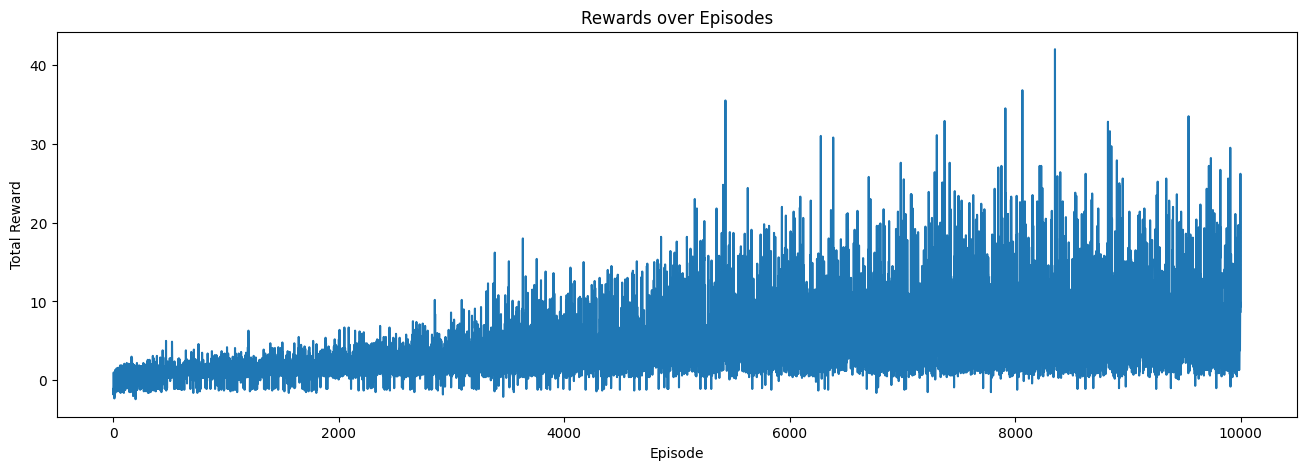

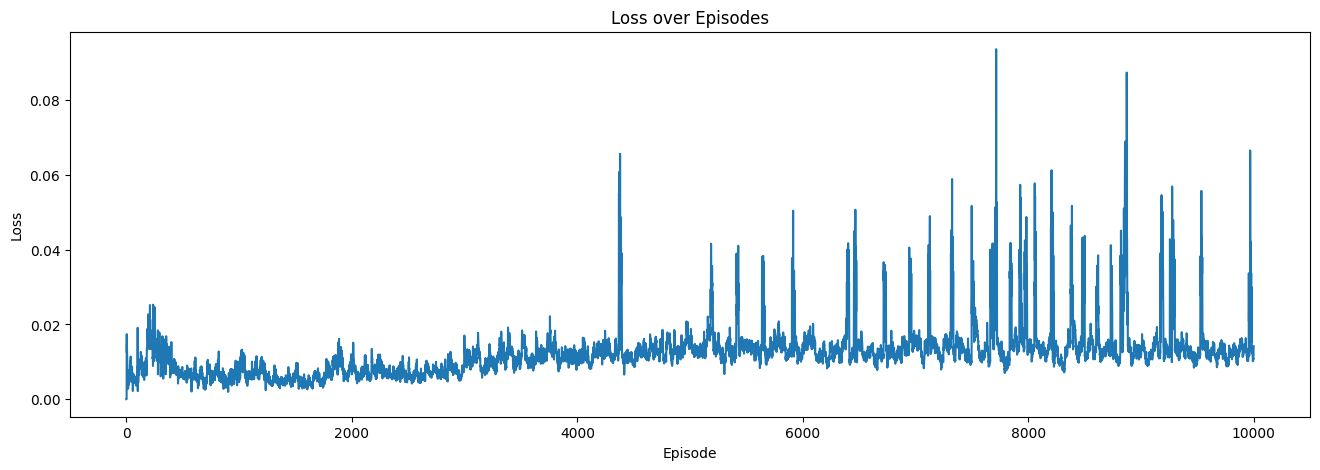

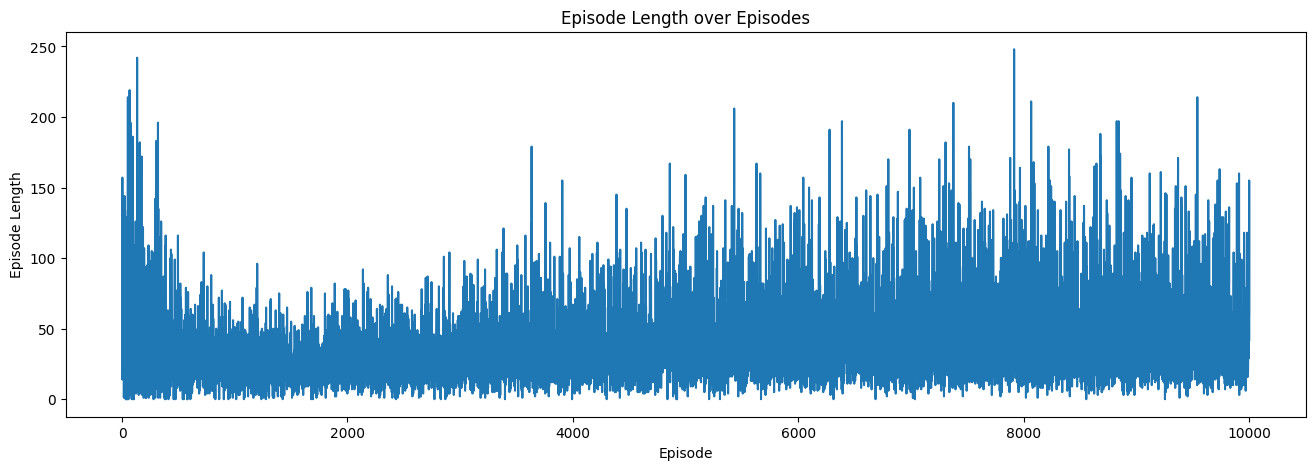

In [14]:

plt.figure(figsize=(16, 5))
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Rewards over Episodes')
plt.show()

plt.figure(figsize=(16, 5))
plt.plot(losses)
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.title('Loss over Episodes')
plt.show()

plt.figure(figsize=(16, 5))
plt.plot(lengths)
plt.xlabel('Episode')
plt.ylabel('Episode Length')
plt.title('Episode Length over Episodes')
plt.show()


Inference, see how the trained model performs

In [28]:
env = UnityEnvironment(file_name="unity_builds/snake", seed=0, side_channels=[], no_graphics=False)
env.reset()

behaviour_name = list(env.behavior_specs)[0]
spec = env.behavior_specs[behaviour_name]

n_actions = spec.action_spec.discrete_branches[0]
state, _ = env.get_steps(behaviour_name)
state = state.obs[0]
n_observations = spec.observation_specs[0].shape[0]

for t in range(5):
    env.reset()
    decision_steps, terminal_steps = env.get_steps(behaviour_name)
    state = decision_steps.obs[0]
    state = torch.tensor(state, dtype=torch.float32, device=device)
    while True:
        with torch.no_grad():
            action = policy_net(state).max(1).indices.view(1, 1)
        action_tuple = ActionTuple()
        action_tuple.add_discrete(action.cpu().numpy())
        env.set_actions(behaviour_name, action_tuple)
        env.step()

        decision_steps, terminal_steps = env.get_steps(behaviour_name)
        observation = decision_steps.obs[0]
        # print(observation)
        done = len(decision_steps) == 0
        terminated = len(terminal_steps) > 0

        if done or terminated:
            break
        state = torch.tensor(observation, dtype=torch.float32, device=device)
env.close()